# 久期：Python 实操 1

本讲包含三个模块：

1. 理论验证：从公式到 Python；
2. 投资组合久期与免疫策略；
3. 主动久期策略模拟。

所有代码均可在 VS Code 的 Jupyter 环境中直接运行。

> [ChatGPT 对话过程](https://chatgpt.com/share/690bfd9a-cffc-8005-a49d-92b9208cb91a)

## 理论验证：从公式到 Python

本节通过 Python 函数计算债券价格、麦考利久期与修正久期，并验证价格–利率的线性近似关系。

麦考利久期 D_mac = 4.55 年
修正久期 D_mod = 4.33 年


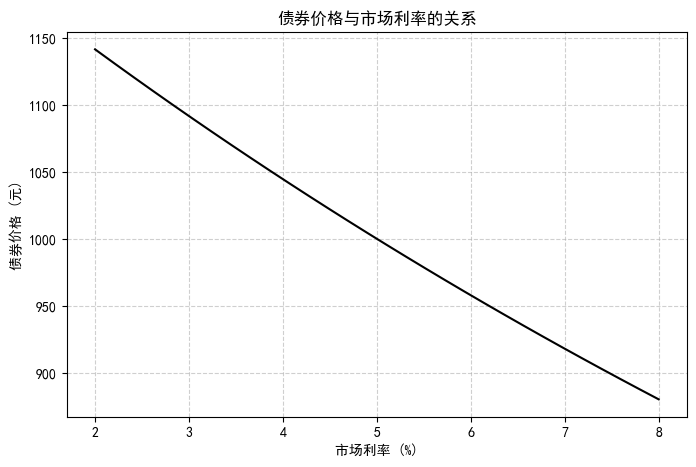

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def price_bond(face, coupon_rate, ytm, maturity, freq=1):
    periods = int(maturity * freq)
    coupon = face * coupon_rate / freq
    cashflows = np.repeat(coupon, periods)
    cashflows[-1] += face
    discount_factors = 1 / (1 + ytm/freq) ** np.arange(1, periods+1)
    return np.sum(cashflows * discount_factors)

def macaulay_duration(face, coupon_rate, ytm, maturity, freq=1):
    periods = int(maturity * freq)
    coupon = face * coupon_rate / freq
    cashflows = np.repeat(coupon, periods)
    cashflows[-1] += face
    discount_factors = 1 / (1 + ytm/freq) ** np.arange(1, periods+1)
    pv_cashflows = cashflows * discount_factors
    weights = pv_cashflows / np.sum(pv_cashflows)
    time = np.arange(1, periods+1) / freq
    return np.sum(weights * time)

def modified_duration(face, coupon_rate, ytm, maturity, freq=1):
    D_mac = macaulay_duration(face, coupon_rate, ytm, maturity, freq)
    return D_mac / (1 + ytm/freq)

face, coupon_rate, maturity = 1000, 0.05, 5
ytms = np.linspace(0.02, 0.08, 30)
prices = [price_bond(face, coupon_rate, y, maturity) for y in ytms]
D_mac = macaulay_duration(face, coupon_rate, 0.05, maturity)
D_mod = modified_duration(face, coupon_rate, 0.05, maturity)
print(f'麦考利久期 D_mac = {D_mac:.2f} 年')
print(f'修正久期 D_mod = {D_mod:.2f} 年')
plt.figure(figsize=(8,5))
plt.plot(ytms*100, prices, color='black')
plt.title('债券价格与市场利率的关系')
plt.xlabel('市场利率 (%)')
plt.ylabel('债券价格 (元)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 投资组合久期与免疫策略

本节演示如何构建满足 $D_p = D_L$ 的资产组合，从而实现久期免疫。

为实现久期免疫: 投资于短期债券 A 的权重 w = 0.533
投资于长期债券 B 的权重 1-w = 0.467


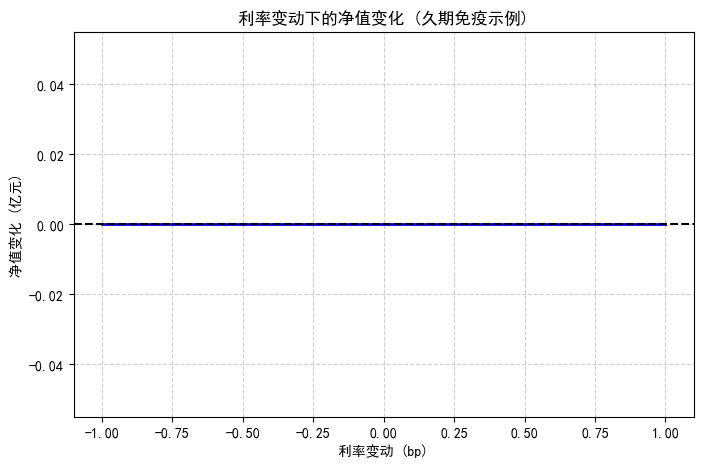

In [3]:
D_A, D_B, D_L = 4.5, 12, 8
w = (D_B - D_L) / (D_B - D_A)
print(f'为实现久期免疫: 投资于短期债券 A 的权重 w = {w:.3f}')
print(f'投资于长期债券 B 的权重 1-w = {1-w:.3f}')
def pv(value, duration, delta_y):
    return value * (1 - duration * delta_y)
y_changes = np.linspace(-0.01, 0.01, 21)
E = []
for dy in y_changes:
    A_val = pv(100, w*D_A+(1-w)*D_B, dy)
    L_val = pv(100, D_L, dy)
    E.append(A_val - L_val)
plt.figure(figsize=(8,5))
plt.plot(y_changes*100, E, color='blue', lw=2)
plt.axhline(0, color='black', linestyle='--')
plt.title('利率变动下的净值变化 (久期免疫示例)')
plt.xlabel('利率变动 (bp)')
plt.ylabel('净值变化 (亿元)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 主动久期策略模拟

通过调整投资组合久期 (D)，观察利率变化下的收益放大效应。

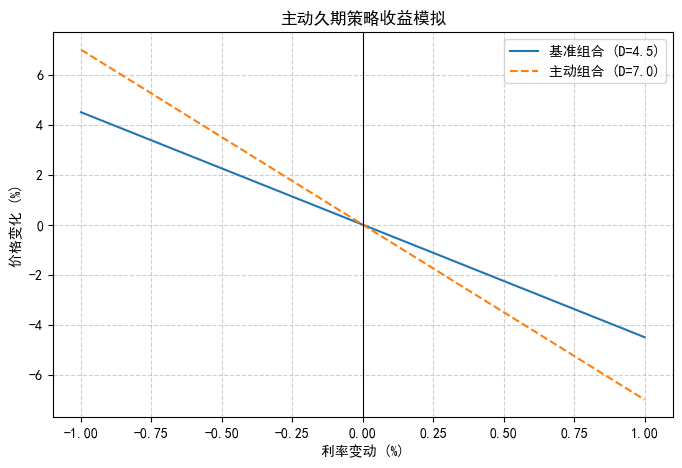

若利率下降 50bp，主动组合的超额收益约为 1.25%


In [4]:
D_bench, D_active = 4.5, 7.0
rate_changes = np.linspace(-0.01, 0.01, 21)
bench_returns = -D_bench * rate_changes
active_returns = -D_active * rate_changes
plt.figure(figsize=(8,5))
plt.plot(rate_changes*100, bench_returns*100, label='基准组合 (D=4.5)')
plt.plot(rate_changes*100, active_returns*100, label='主动组合 (D=7.0)', linestyle='--')
plt.axvline(0, color='black', lw=0.8)
plt.title('主动久期策略收益模拟')
plt.xlabel('利率变动 (%)')
plt.ylabel('价格变化 (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
Δy = -0.005
excess = (D_active - D_bench)*(-Δy)*100
print(f'若利率下降 50bp，主动组合的超额收益约为 {excess:.2f}%')